# Chapter 4 - Evaluation and Optimization

In [24]:
%pylab inline
import pandas as pandas

Populating the interactive namespace from numpy and matplotlib


We generate two inputs:
* features – a matrix of input features
* target – an array of target variables corresponding to those features

In [6]:
features = rand(100,5)
target = rand(100) > 0.5

### The holdout method

We divide into a randomized training and test set:

In [10]:
int(floor(0.7*100))

70

In [15]:
N = features.shape[0]
N_train = int(floor(0.7 * N))

# Randomize index
# Note: sometimes you want to retain the order in the dataset and skip this step
# E.g. in the case of time-based datasets where you want to test on 'later' instances
idx = random.permutation(N)

# Split index
idx_train = idx[:N_train]
idx_test = idx[N_train:]

# Break your data into training and testing subsets
features_train = features[idx_train,:]
target_train = target[idx_train]
features_test = features[idx_test,:]
target_test = target[idx_test]

# Build, predict, evaluate (to be filled out)
# model = train(features_train, target_train)
# preds_test = predict(model, features_test)
# accuracy = evaluate_acc(preds_test, target_test)

In [16]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(70, 5)
(30, 5)
(70,)
(30,)


### K-fold cross-validation

In [18]:
N = features.shape[0]
K = 10 # number of folds

preds_kfold = np.empty(N)
folds = np.random.randint(0, K, size=N)

for idx in np.arange(K):

    # For each fold, break your data into training and testing subsets
    features_train = features[folds != idx,:]
    target_train = target[folds != idx]
    features_test = features[folds == idx,:]
    
    # Print the indices in each fold, for inspection
    print(nonzero(folds == idx)[0])

    # Build and predict for CV fold (to be filled out)
    # model = train(features_train, target_train)
    # preds_kfold[folds == idx] = predict(model, features_test)
    
# accuracy = evaluate_acc(preds_kfold, target)

[29 44 46 59 85 97]
[12 15 16 19 25 40 56 66 73 75 81 84 89 94]
[ 2  9 18 21 24 26 42 49 53 67 70 76 80]
[ 5 60 72 74 90]
[ 1  6 14 22 27 35 37 55 62 68 88 95]
[ 0  4  8 11 23 32 45 47 51 58 87 96]
[10 39 93]
[ 7 13 17 20 31 38 52 63 78 79]
[ 3 28 41 57 64 65 71 83 91 98]
[30 33 34 36 43 48 50 54 61 69 77 82 86 92 99]


### The ROC curve

In [19]:
def roc_curve(true_labels, predicted_probs, n_points=100, pos_class=1):
    thr = linspace(0,1,n_points)
    tpr = zeros(n_points)
    fpr = zeros(n_points)

    pos = true_labels == pos_class
    neg = logical_not(pos)
    n_pos = count_nonzero(pos)
    n_neg = count_nonzero(neg)
      
    for i,t in enumerate(thr):
        tpr[i] = count_nonzero(logical_and(predicted_probs >= t, pos)) / n_pos
        fpr[i] = count_nonzero(logical_and(predicted_probs >= t, neg)) / n_neg
    
    return fpr, tpr, thr


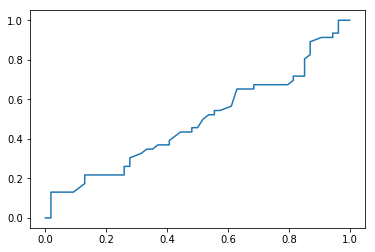

In [20]:
# Randomly generated predictions should give us a diagonal ROC curve
preds = rand(len(target))
fpr, tpr, thr = roc_curve(target, preds, pos_class=True)
plot(fpr, tpr)

### The area under the ROC curve

In [21]:
def auc(true_labels, predicted_labels, pos_class=1):
    fpr, tpr, thr = roc_curve(true_labels, predicted_labels,
 pos_class=pos_class)
    area = -trapz(tpr, x=fpr)
    return area

In [22]:
auc(target, preds, pos_class=True)

0.48973429951690817

### Multi-class classification

In [25]:
d = pandas.read_csv("data/mnist_small.csv")
d_train = d[:int(0.8*len(d))]
d_test = d[int(0.8*len(d)):]

In [26]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(d_train.drop('label', axis=1), d_train['label'])

C:\Users\thimo\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [27]:
from sklearn.metrics import confusion_matrix
preds = rf.predict(d_test.drop('label', axis=1))
cm = confusion_matrix(d_test['label'], preds)

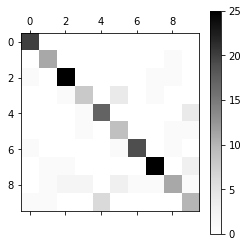

In [29]:
matshow(cm, cmap='Greys')
colorbar()
savefig("figures/figure-4.19.eps", format='eps')

### The root-mean-square error

In [30]:
def rmse(true_values, predicted_values):
    n = len(true_values)
    residuals = 0
    for i in range(n):
        residuals += (true_values[i] - predicted_values[i])**2.
    return np.sqrt(residuals/n)

In [31]:
rmse(rand(10), rand(10))

0.523376239728872

### The R-squared error

In [32]:
def r2(true_values, predicted_values):
    n = len(true_values)
    mean = np.mean(true_values)
    residuals = 0
    total = 0
    for i in range(n):
        residuals += (true_values[i] - predicted_values[i])**2.
        total += (true_values[i] - mean)**2.
    return 1.0 - residuals/total

In [33]:
r2(arange(10)+rand(), arange(10)+rand(10))

0.9848685790938427

### Grid search with kernel-SVM model

Importing modules:

In [34]:
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC

Loading data and performang poor-mans feature engineering:

In [67]:
d = pandas.read_csv("data/titanic.csv")

# Target
y = d["Survived"]

# Features
X = d.drop(["Survived", "PassengerId", "Cabin","Ticket","Name", "Fare"], axis=1)
X['Sex'] = list(map(lambda x: 1 if x=="male" else 0, X['Sex']))
X['Embarked-Q'] = list(map(lambda x: 1 if x=="Q" else 0, X['Embarked']))
X['Embarked-C'] = list(map(lambda x: 1 if x=="C" else 0, X['Embarked']))
X['Embarked-S'] = list(map(lambda x: 1 if x=="S" else 0, X['Embarked']))
X = X.drop(["Embarked", "Sex"], axis=1)
X = X.fillna(-1)

In [68]:
#X.head(5)
N
#folds = np.random.randint(0, K, size=N)
#folds
X_train=X.iloc[folds,:]
print(type(X_train))
#X_train = X_train.drop(1)
#X_train
X_test = X.iloc[folds, :]
X_test = X_test[folds == ii]
X_test

<class 'pandas.core.frame.DataFrame'>


,Pclass,Age,SibSp,Parch,Embarked-Q,Embarked-C,Embarked-S
0,3,22.0,1,0,0,0,1
0,3,22.0,1,0,0,0,1
0,3,22.0,1,0,0,0,1
0,3,22.0,1,0,0,0,1
0,3,22.0,1,0,0,0,1
0,3,22.0,1,0,0,0,1
0,3,22.0,1,0,0,0,1
0,3,22.0,1,0,0,0,1
0,3,22.0,1,0,0,0,1
0,3,22.0,1,0,0,0,1


Performing grid-search to find the optimal hyper-parameters:

In [71]:
# grid of (gamma, C) values to try 
gam_vec, cost_vec = np.meshgrid(np.linspace(0.01, 10, 11),
                     np.linspace(0.01, 10, 11))

AUC_all = [] # initialize empty array to store AUC results

# set up cross-validation folds
N = len(y)
K = 10 # number of cross-validation folds
folds = np.random.randint(0, K, size=N)

# search over every value of the grid
for param_ind in np.arange(len(gam_vec.ravel())):

    # initialize cross-validation predictions
    y_cv_pred = np.empty(N)

    # loop through the cross-validation folds
    for ii in np.arange(K):
        # break your data into training and testing subsets
        # X_train = X.ix[folds != ii,:]
        # y_train = y.ix[folds != ii]
        # X_test = X.ix[folds == ii,:]
        X_train = X.iloc[folds != ii,:]
        y_train = y.iloc[folds != ii]
        X_test = X.iloc[folds == ii,:]
        #X_train = X.iloc[folds, :]
        #X_train = X_train.drop(ii)
        #y_train = y.iloc[folds]
        #y_train = y.drop(ii)
        #X_test = X.iloc[folds, :]
        #X_test = X_test[folds == ii]
        
        # build a model on the training set
        model = SVC(gamma=gam_vec.ravel()[param_ind], C=cost_vec.ravel()[param_ind])
        model.fit(X_train, y_train)

        # generate and store model predictions on the testing set
        y_cv_pred[folds == ii] = model.predict(X_test)

    # evaluate the AUC of the predictions
    AUC_all.append(roc_auc_score(y, y_cv_pred))

indmax = np.argmax(AUC_all)
print("Maximum = %.3f" % (np.max(AUC_all)))
print("Tuning Parameters: (gamma = %.2f, C = %.2f)" % (gam_vec.ravel()[indmax], cost_vec.ravel()[indmax]))

Maximum = 0.681
Tuning Parameters: (gamma = 0.01, C = 4.01)


Plotting the contours of the parameter performance:

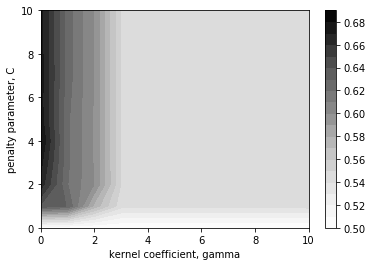

In [72]:
AUC_grid = np.array(AUC_all).reshape(gam_vec.shape)

contourf(gam_vec, cost_vec, AUC_grid, 20, cmap='Greys')
xlabel("kernel coefficient, gamma")
ylabel("penalty parameter, C")
colorbar()
savefig("figures/figure-4.25.eps", format='eps')